# 1. Эпизод первый. Сегментация клиентов.

Добро пожаловать в первую тетрадку по машинному обучению в этом году! Прошлый курс [мы закончили кластеризацией.](http://nbviewer.jupyter.org/github/FUlyankin/HSE_Data_Culture/blob/master/Introduction%20to%20data%20sciene%202018%20spring/Introduction_to_DS_6_Кластеризация.ipynb) Этот курс мы с неё начнём! Расслабьтесь и получайте удовольствие. 


### Немного про задачу сегментации и машинное обучение 

Сегмент – это группа потенциальных или уже существующих клиентов, для определенного набора продуктов или услуг, со схожим набором потребностей, которые друг на друга ориентируются при принятии решений о покупке. С помощью машинного обучения можно выделять сегменты среди клиентов автоматически.

Как обычно, начнём нашу тетрадку с подгрузки необходимых пакетов.

In [1]:
import pandas as pd    # пакет для работы с таблицами 
import numpy as np     # пакет для работы с матрицами 

# пакеты для картиночек 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # правильный (наиболее красивый) стиль у графиков

%matplotlib inline

import datetime as dt # пакет для работы с датами 

Все пакеты выше вам уже знакомы. Но этого мало. Нам понадобятся ещё кое-какие библиотеки. Обычно подгрузку делают самым первым блоком, но мы будем её делать по мере необходимости, чтобы вы понимали какая библиотека что делает. Не вздумайте пугаться! Питоновские библиотеки чувствуют ваш страх.

## 1.1 Первое знакомство с данными

In [2]:
# подгружаем данные из экселевской таблички
df = pd.read_excel('Online Retail.xlsx')

In [3]:
# размер датасета
df.shape

(541909, 8)

In [4]:
# внешний вид датасета
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Итак, в нашем распоряжении оказались [данные электронной коммерции.](https://www.kaggle.com/carrie1/ecommerce-data/home) Как правило, такие наборы данных частные и хранятся фирмами под грифом секретности. Тем не менее, один британский интернет-магазин решил поделиться своими транзакциями за $2010-2011$ годы. По большей части магазин продаёт подарки. Чаще всего оптом. 

![](http://memesmix.net/media/created/12w25n.jpg) 

__Немного подробнее про переменные:__

* `InvoiceNo` - номер счета, 6-значное целое число уникальное для каждой сделки. Если этот код начинается с буквы "c", это означает отмену покупки. 
* `StockCode` - код товара, 5-значный номер, уникальный для каждого товара.
* `Description` - описание того, какие товары были куплены.
* `Quantity` - закупленное количество.
* `InvoiceDate` - дата транзакции.
* `UnitPrice` - цена за единицу в фунтах.
* `CustomerID` - код клиента.
* `Country` - страна, в которой проживает клиент.

## 1.2 Чистка данных

Посмотрим на число пропусков в наших переменных. Мы тут собираемся заняться сегментацией клиентов, у части записей почему-то нет клиентского ID. Как таких сегментировать не очень понятно. Давайте выбросим все записи, в которых есть пропуски. 

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
# сделаем customerID целым числом
df['CustomerID'] = df['CustomerID'].astype(int)

Посмотрим на основную числовую статистику по данным, возможно нам удастся найти какие-то гадости.

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Гадости нашлись. Почему-то в записях присутствуют отрицательные покупки. Если чуть внимательнее вчитаться в описание переменных, то можно заметить, что некоторые сделки помечаются маркером `c` и соответствуют возвратам. Давайте очистим датасет от возвратов.

Второй странностью является наличие нулевых цен. Их тоже выкинем из датасета. Часто при записи логов совершаются ошибки. Всегда перед тем, как строить модель, изучите данные на наличие аномалий, несостыкующихся с природой и здравым смыслом.

In [10]:
df = df[(df.Quantity > 0) & (df.UnitPrice > 0)]

Посмотрим сколько осталось строчек.

In [11]:
df.shape

(397884, 8)

С чисткой всё. Переходим к варке фичей. 

## 1.3  Exploration & Feature Engineering

Введём переменную - цена всего заказа. Пока что в данных она указана за штуку.

In [12]:
df['TotalPrice'] = df.Quantity * df.UnitPrice

Посмотрим из каких стран наши клиенты. Для этого оставим в нашей табличке только уникальные айдищники покупателей. 

In [13]:
countryCust = df.drop_duplicates(subset=['CustomerID']).Country.value_counts()
countryCust[:10]

United Kingdom    3920
Germany             94
France              87
Spain               28
Belgium             24
Switzerland         20
Portugal            19
Italy               14
Finland             12
Norway              10
Name: Country, dtype: int64

Text(0.5,1,'Number of Customers per Country')

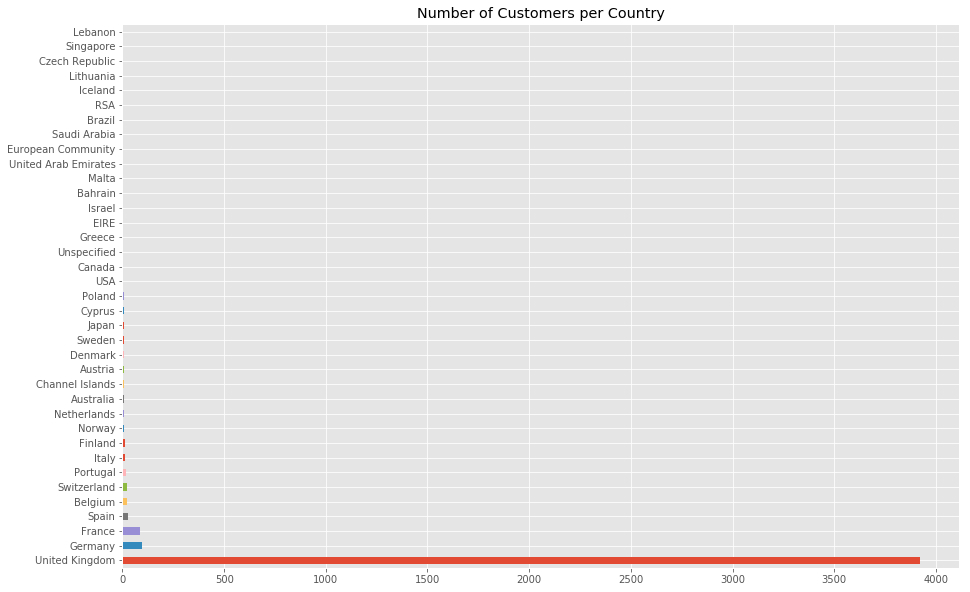

In [14]:
countryCust.plot(kind='barh', figsize=(15,10))
plt.title('Number of Customers per Country')

Магазин Британский. Вполне ожидаемо, что большая часть клиентуры приходится на страны Европы. Теперь давайте посмотрим на какую страну приходится какое количество транзакций.

Text(0.5,1,'Number of Invoices per Country')

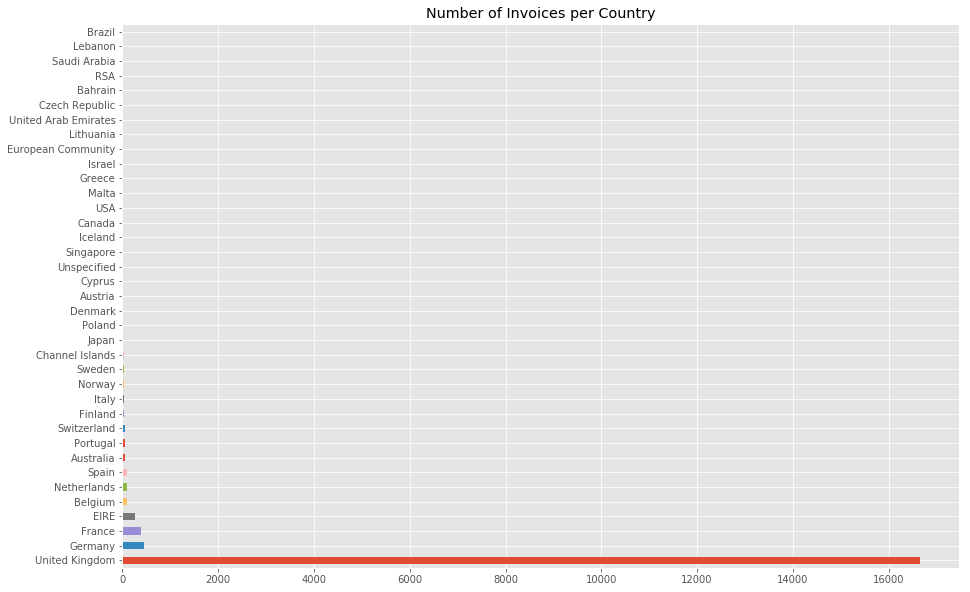

In [15]:
countryInv = df.drop_duplicates(subset=['InvoiceNo']).Country.value_counts()
countryInv.plot(kind='barh', figsize=(15,10))
plt.title('Number of Invoices per Country')

По-прежнему Европа остаётся в топе. Попробуем найти из какой страны приходят самые классные покупатели: покупатели, которые тратят в среднем на одну транзакцию больше всего денег. 

Text(0.5,1,'Average Basket Price per Country')

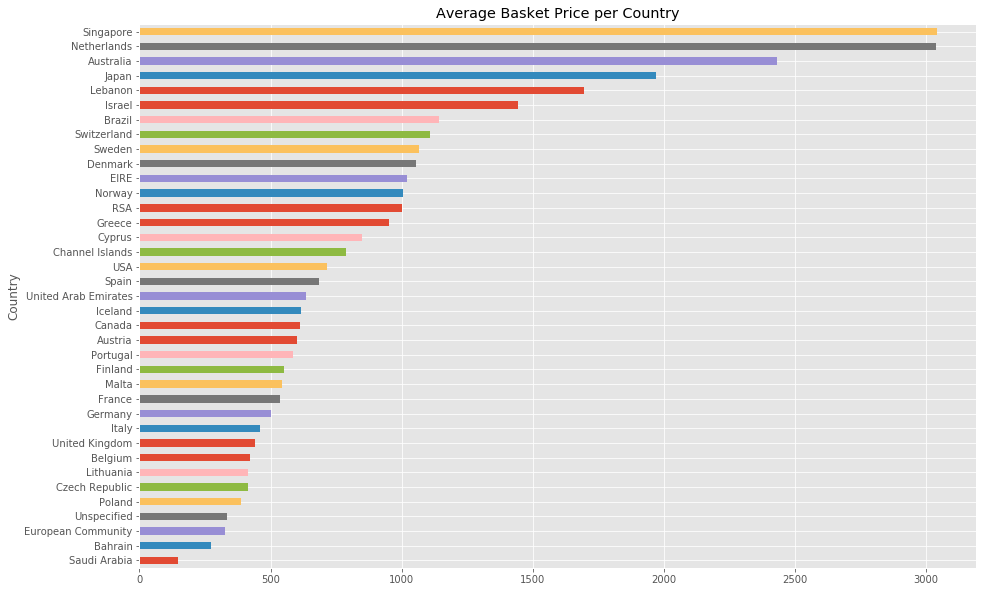

In [16]:
bestBuyer = df.groupby(['Country', 'InvoiceNo'])['TotalPrice'].sum().reset_index().groupby(['Country'])['TotalPrice'].mean().sort_values()
bestBuyer.plot(kind='barh', figsize=(15,10))
plt.title("Average Basket Price per Country")

Неожиданно выясняется, что больше всего денег на одну транзацию тратит вовсе не Европа. В среднем самые крупные закупки приходят из Сингапура. Давайте введём дополнительную порядковую переменную, которая будет отражать из какой страны (по объёму закупок) наш клиент.

In [17]:
countryRankSorted = bestBuyer.rank().to_dict()
df['CountryRank'] = df["Country"].apply(lambda x:countryRankSorted[x])
df.head( )

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,CountryRank
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,9.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,9.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,9.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,9.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,9.0


Пришло время поработать с описанием покупок. Именно по ним мы будем делать сегментацию с помощью методов машинного обучения. Посмотрим сколько у нас есть уникальных описаний и начнём подгружать библиотеки, необходимые для работы с текстами.

In [18]:
X = df["Description"].unique()
len(X)

3877

Перед тем как строить по корпусу из текстов каки-либо модели, нужно превратить тексты в цифры. Математика работает только с цифрами, а кластеризация ещё та математика. Во-первых, сделаем все буквы строчными. Во-вторых, разрубим все тексты на состовляющие их слова. Такую разрубку называют токенизацией. 

In [19]:
text = X[15]
text

'BOX OF VINTAGE JIGSAW BLOCKS '

In [20]:
tokens = text.lower().split(' ')
tokens

['box', 'of', 'vintage', 'jigsaw', 'blocks', '']

Обычно, при работе с текстами руководствуются гипотезой, которая называется мешком слов. Смысл этой гипотезы состоит в том, что порядок слов в предложении никак не сказывается на его смысле.

* Порядок слов неважен
* Неважен порядок слов
* Слов порядок неважен
* Порядок неважен слов
* Слов неважен порядок
* Неважен слов порядок

Конечно же с этой гипотезой можно поспорить и для этого вам придётся схлеснуться в словесной дуэли с одним известным персонажем.

![ ](https://i.ytimg.com/vi/8neiFnhQJms/hqdefault.jpg) 

Главным аргументом с вашей стороны, скорее всего, будет частица не, положение которой в предложении может координально влиять на смысл фразы. Да, порядок слов иногда важен. Тем не менее при моделировании мы должны чем-то жертвовать. Справедливости ради стоит отметить, что существует ряд более сложных моделей, которые учитывают порядок слов, но мы не будем их касаться в этом курсе. По крайней мере пока. Тем более, интуиция подсказывает, что пренебрежение порядком слов не должно никак сказаться на выделении сегментов.

Если вы помните, мы не можем сделать со словами OHE, потому что это приведёт к появлению слишком большого числа переменных. Нам нужно как-то сжать пространство слов, выкинув не очень важные. 

Например, в текстах часто встречаются предлоги. Они не несут никакой смысловой информации о сути текста Найдётся огромное количество подобной лексики, которая для нашего набора текстов встречается повсеместно и не несёт никакой информации. Обычно такие частые слова называют стоп-словами. Они путают нашу модель, перетягивая на себя внимание. От них необходимо избавиться. Исследователи завели специальные списки с такими словами и положили их в пакеты. Давайте подгрузим один из таких списков.

In [21]:
import nltk  # пакет для работы с естественным языком

# если компухтер ругается и выдаёт ошибку
# проделайте в отдельной ячейке команду nltk.download('stopwords')
# она скачает на ваш комп наборы из стоп-слов
# при желании можно проделать nltk.download( ), тогда скачается вообще все
# наборы данных из пакета, но это займёт много времени

# подгрузили список стоп-слов
stopword = nltk.corpus.stopwords.words('english')  

stopword[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Будем выкидывать слово из текста, если оно является стоп-словом. 

In [22]:
tokens

['box', 'of', 'vintage', 'jigsaw', 'blocks', '']

In [23]:
[token for token in tokens if token not in stopword]

['box', 'vintage', 'jigsaw', 'blocks', '']

Неплохо было бы избавиться от небукв. Метод `.isalpha()` проверяет является ли объект буквенным.

In [24]:
print('box'.isalpha())
print('55'.isalpha())
print('box55'.isalpha())
print('bo-x'.isalpha())

True
False
False
False


In [25]:
[token for token in tokens if token not in stopword and token.isalpha()]

['box', 'vintage', 'jigsaw', 'blocks']

Другим естественым путём для уменьшения числа переменных является приведение всех слов к одной форме, __нормализация.__ Хочется избавиться от окончаний, суффиксов и приставок. Сделать это можно двумя путями:

1. Обрубив их и оставить только корневую основу. Такой способ называется __стемминг__.
2. Привести по словорям вся существительные к единственному числу именительному падежу, глаголы к инфенитиву и тд. Такой способ называется __лемматизация__. Для неё нужен специальный словарь. Для русского языка такой словарь можно найти в пакете `pyborthy2`.

Мы займёмся стемингом. Он довольно хорошо работает для английского языка из-за его примитивности. Для русского лучше использовать лемматизацию.

In [26]:
# объявили стеммер
stemmer = nltk.stem.porter.PorterStemmer()

In [27]:
[stemmer.stem(token) for token in tokens if token not in stopword and token.isalpha()]

['box', 'vintag', 'jigsaw', 'block']

Остался последний момент: а как собственно подсчитать слова? Мы с вами на предыдущем семинаре обсуждали два способа. Давайте вспомним их.  Пусть у нас в коллекции есть два текста: 

1. Акции Газпрома выросли на 5%. Акции Сбербанка упали на 1%. 
2. Акции ВТБ выросли на 2%.

Тогда, опуская числа, мы можем сказать, что весь наш корпус содержит следующие уникальные слова: `акции, газпрома, выросли, на, сбербанка, упали, ВТБ`. Данный набор принято называть словарем корпуса. Теперь мы можем представить каждый документ в виде вектора в семимерном пространстве, где каждое измерение соответствует определенному слову из словаря. Теперь тот же самый корпус имеет следующее представление:

1. $[2;1;1;2;1;1;0]$
2. $[1;0;1;1;0;0;1]$

В питоне такую штуку позволяет сделать класс `CountVectorizer`.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer() # объявили

# обучили
tt = CV.fit_transform(['Акции Газпрома выросли на. Акции Сбербанка упали на', 'Акции ВТБ выросли на'])
tt.toarray() # посмотрели

array([[2, 0, 1, 1, 2, 1, 1],
       [1, 1, 1, 0, 1, 0, 0]], dtype=int64)

Дальше можно учить модель. Однако мы с ввами очень крутые, а такой подход не очень крутой. Давайте приведём подход в соответствие нашей крутости. Будем использовать tf-idf. Предпосылки: 

1. Порядок слов неважен.
2. Если слово встречается в документе часто и оно не является стоп-словом, скорее всего, оно важное. Эту тенденцию отражает показатель tf (сокращение от английского term frequency, частота слова). Чтобы получить tf, нам просто нужно нормализовать матрицу, которую на нас выплюнул `CountVectorizer`.
3. Если слово встречается в других документах реже, чем в данном, то, скорее всего, оно также важное, так как описывает специфику документа и отличает его от других. Эту тенденцию отражает показатель idf (сокращение от inverse document frequency, обратная частота документа). Обычно idf расчитывают как: 

$$
idf = \ln \left( \frac{\text{всего документов в корпусе}}{\text{число документов, содержащих слово i}} \right)
$$

Логарифм берётся, чтобы сгладить очень большие числа. Перемножив tf и idf мы учтём оба факта важности слова и получим tf-idf представление текста. Попробуем сделать это в питоне.

In [29]:
from sklearn.feature_extraction.text import  TfidfVectorizer

tfidf =  TfidfVectorizer() # объявили

# обучили
tt = tfidf.fit_transform(['Акции Газпрома выросли на. Акции Сбербанка упали на', 'Акции ВТБ выросли на'])
tt.toarray() # посмотрели

array([[0.51767635, 0.        , 0.25883818, 0.36378803, 0.51767635,
        0.36378803, 0.36378803],
       [0.44832087, 0.63009934, 0.44832087, 0.        , 0.44832087,
        0.        , 0.        ]])

Чем больше tf-idf, тем важнее слово для коллекции документов. Мы почти у цели. Можно объединить предобработку и tf-idf векторизатор в единое целое. Делается это как-то так: 

In [30]:
# объявили 
analyzer = TfidfVectorizer().build_analyzer()

# фкнкция для стеминга и фильтрации
def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

# опции: 
# lowercase сделала регистр нижним
# stop_words выбросит стоп-слова
# analyzer - функция для предобработки
# min_df, max_df - границы, в рамках которых будут лежать tf
# отрегулировав эти границы мы можем выкинуть слишком редкие и слишком частые слова
# в качестве границ можно указывать либо количество либо долю

tfidf = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=3, max_df=0.3)  

# трансформация
X_tfidf = tfidf.fit_transform(X)
print("Размеры нашей матрицы:", X_tfidf.shape)

Размеры нашей матрицы: (3877, 853)


С предобработкой на этом всё. Давайте займёмся аналитикой.

## 1.4 RFM-сегментация

RFM аббревиатура (англ. Recency Frequency Monetary — давность, частота, деньги) — сегментация клиентов в анализе сбыта по лояльности. Определяет три группы:

* __Recency (давность)__ — давность сделки, чем меньше времени прошло с момента последней активности клиента, тем больше вероятность, что он повторит действие.
* __Frequency (частота)__ — количество сделок, чем больше каких-либо действий совершит клиент, тем больше вероятность того, что он его повторит в будущем.
* __Monetary (деньги)__ — сумма сделок, чем больше денег было потрачено, тем больше вероятность того, что он сделает заказ.

Делаем по данным UK, так как магизин Британский и большая часть покупателей оттуда. 

In [31]:
df1 = df[df.Country == 'United Kingdom']

In [32]:
df1.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

In [33]:
now = dt.datetime(2011,12,10)

In [34]:
rfm = df1.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days, 
                                     'InvoiceNo': lambda x: len(x), 
                                     'TotalPrice': lambda x: x.sum()})

In [35]:
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']

In [36]:
rfm.head( )

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,325,1,77183.60
12747,2,103,4196.01
12748,0,4595,33719.73
12749,3,199,4090.88
12820,3,59,942.34


!!!NB наверное, надо как-то это прокомментировать... 

## 1.5  Сегментация методами машинного обучения

Наконец мы дорвались до кластеризации. Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи. Перечисленные алгоритмы ни в коем случае не описывают данное множество полностью, но являются примерами самых популярных методов решения задачи кластеризации.


### K-means

Алгоритм К-средних, наверное, самый популярный и простой алгоритм кластеризации и очень легко представляется в виде простого псевдокода:

1. Выбрать количество кластеров $k$, которое нам кажется оптимальным для наших данных.
2. Высыпать случайным образом в пространство наших данных $k$ точек (центроидов).
3. Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.
4. Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
5. Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

In [37]:
from sklearn.cluster import KMeans

# будем искать 10 сегментов
kmeans = KMeans(n_clusters = 10)  

kmeans.fit(X_tfidf)  # обучаем
clusters = kmeans.predict(X_tfidf) # приписываем каждому наблюдению свой кластер
clusters

array([3, 2, 0, ..., 6, 3, 0], dtype=int32)

Отлично! Теперь мы знаем к какому кластеру относится какое наблюдение. Однако у нас есть проблемка. Из-за того, что у нас нет никакой исходной разметки и вообще тестовой выборки, мы не можем оценить насколько кластеризация оказалась удачной. Приходится изголяться и придумывать новые. Одной из таких метрик является __коэффициент силуэта.__

Пусть $a$ - среднее расстояние от данного объекта до объектов из того же кластера. Пусть $b$ — среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина:

$$
s = \frac{b-a}{max(a,b)}
$$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. 

Данная величина лежит в диапазоне $[-1;1]$. Значения, близкие к $-1$, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к $1$, соответствуют "плотным" четко выделенным кластерам. 

Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно попытаться выбирать оптимальное число кластеров — выбирается число кластеров, максимизирующее значение силуэта. Силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах.

In [38]:
from sklearn.metrics import silhouette_score
silhouette_score(X_tfidf, clusters)

0.023588647793393563

Видим, что наши кластеры накладываются друг на друга. Давайте попробуем посмотреть какими словами иллюстрируется первый кластер. Для этого построи диаграмму, которая называется облаком слов. 

(-0.5, 899.5, 899.5, -0.5)

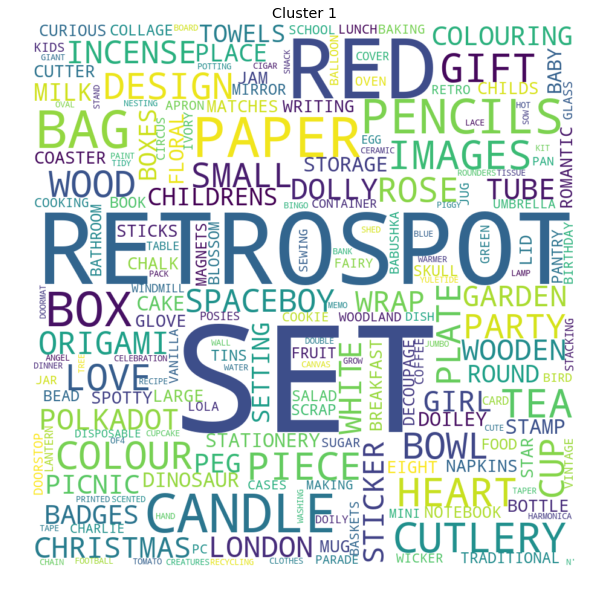

In [39]:
from wordcloud import WordCloud

cluster = 1  # для какого кластера картинка 

# генерируем облако из слов
wordcloud = WordCloud(background_color="white", max_words=200, width=900, height=900, collocations=False)
wc = wordcloud.generate(" ".join(X[np.where(clusters==cluster)]))

# строим картинку
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Cluster {}".format(cluster))
plt.axis("off")

При желании можно построить общую картинку для всех кластеров. 

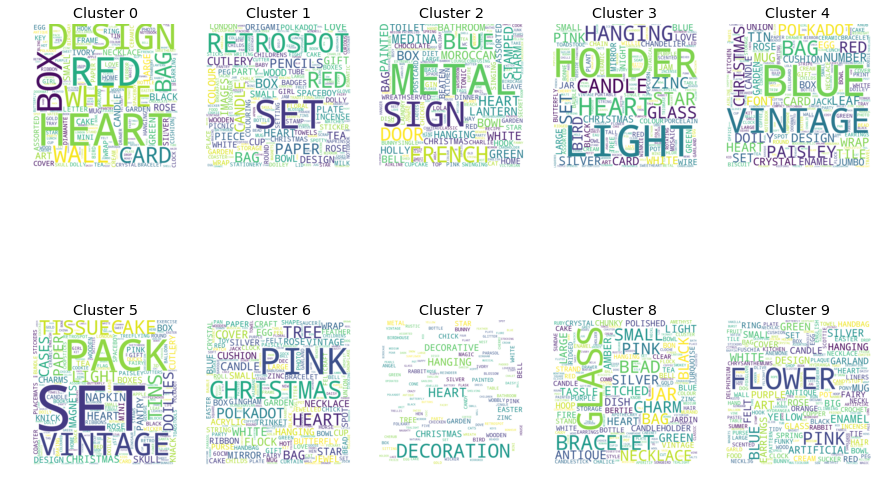

In [40]:
fig = plt.figure(figsize=(15,10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.grid('off')
    ax.axis('off')

    wordcloud = WordCloud(background_color="white", max_words=200, width=900, height=900, collocations=False)
    wc = wordcloud.generate(" ".join(X[np.where(clusters==i)]))

    ax.imshow(wc, interpolation='bilinear')
    ax.set_title("Cluster {}".format(i))

Если немного позалипать на картинки, можно проинтерпретировать кластеры. Из-за наложения кластеров друг на друга, эта интерпретация получится не до конца чёткой. Чтобы получить более чёткие кластеры, можно попробовать побаловаться с параметрами алгоритма либо выбрать более сложный алгоритм. 

Наше дело осталось за малым. Выяснить из каких кластеров какие покупатели делают покупки. 

In [41]:
desc_clust = dict(zip(X, clusters))  # соответствие описание : кластер

# делаем в таблице новую колонку, определив к какому кластеру относится какая транзакция
df['cluster'] = df.Description.replace(desc_clust)

Группируем все покупки по id покупателей. 

In [42]:
df_segm = df.groupby(['CustomerID'])['cluster'].apply(list)
df_segm.head()

CustomerID
12346                                                  [0]
12347    [3, 4, 3, 4, 0, 6, 0, 0, 0, 4, 0, 0, 0, 6, 0, ...
12348    [0, 0, 0, 0, 5, 5, 5, 5, 5, 0, 5, 5, 4, 4, 5, ...
12349    [0, 0, 6, 0, 0, 1, 0, 0, 3, 0, 4, 0, 0, 5, 1, ...
12350    [2, 2, 0, 0, 1, 6, 0, 4, 0, 1, 0, 2, 0, 0, 0, ...
Name: cluster, dtype: object

Смотрим из каких кластеров в каком количестве делаются покупки.

In [43]:
from collections import defaultdict

# функция, подсчитывающая сколько объектов из какого кластера оказалось среди покупок
def count_cluster(vector):
    segment_dict = defaultdict(lambda : 0)
    for item in vector:
        segment_dict[item] += 1
    return sorted(segment_dict.items(), key = lambda w: w[1], reverse=True)

df_segm = df_segm.apply(count_cluster)

Спустя одну стрёмную, вообще непонятно что делающую функцию, получаем результат (подробнее про эту функцию написано в бонусных материалах, которые можно найти на странчике курса). 

Например, посмотрим на покупателя с id 12347. Он фанат нулевого кластера, из него им было сделано больше всего покупок. Если мы делаем для него какую-то рекламную кампанию или акцию, наверное, имеет смысл ориентироваться именно на эту категорию продуктов. 

In [44]:
df_segm[12347]

[(0, 100), (4, 23), (6, 15), (5, 15), (1, 14), (3, 12), (2, 2), (7, 1)]

### Агломеративная или иерархическая кластеризация

Наверное самый простой и понятный алгоритм кластеризации без фиксированного числа кластеров — агломеративная кластеризация. Интуиция у алгоритма очень простая:

1. Начинаем с того, что высыпаем на каждую точку свой кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

По итогам выполнения такого алгоритма можно построить замечательное дерево склеивания кластеров и глядя на него определить, на каком этапе нам было бы оптимальнее всего остановить алгоритм. Либо воспользоваться тем же правилом локтя, что и в k-means.

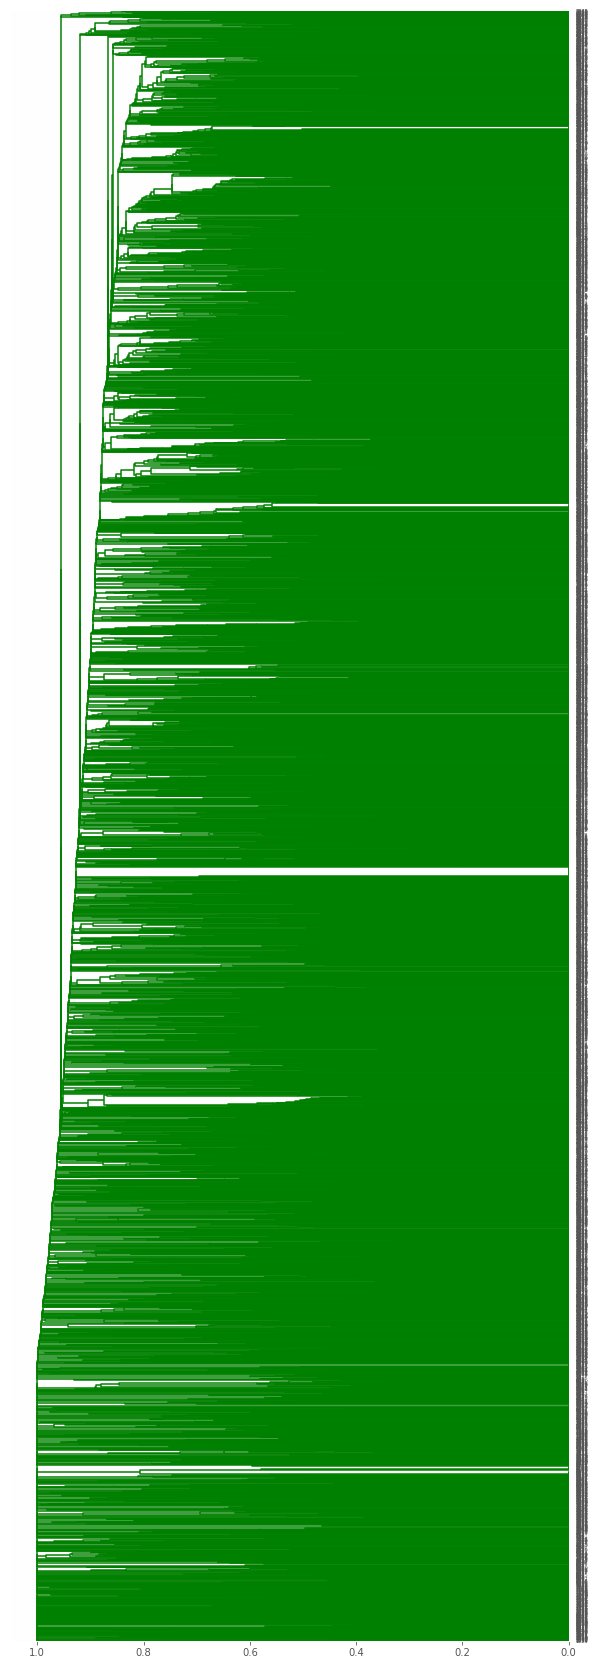

In [49]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# pdist посчитает нам верхний треугольник матрицы попарных расстояний
distance_mat = pdist(X_tfidf.toarray()) 

# linkage — реализация агломеративного алгоритма
Z = hierarchy.linkage(distance_mat, 'single') 

# картинка с деревом (из-за большого числа наблюдений, очень непонятная)
plt.figure(figsize=(10, 30))
dn = hierarchy.dendrogram(Z, color_threshold=2.1, orientation='left')

# Задание: 

* Попытайтесь подобрать оптимальное число кластеров для k-means. 

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации. В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся. 

Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал падает "уже не так быстро".

Внутри цикла сделайте $k-means$ сначала для $2$ кластеров, потом для $3$, ... ,$30$ кластеров. Посчитайте для каждой кластеризации метрику, описанную выше. Нарисуйте картинку, где по оси $x$ будет отложено количество кластеров, а по оси $y$ значение метрики. 

* Ещё раз попытайтесь подобрать оптимальное число кластеров для k-means, но на этот раз максимизируя коэффициент силуэта. Не забудьте построить картинку.
* Попробуйте поиграться с параметрами tf-idf и добиться максимального значения коэффициента силуэта.
* Метод $k$-means очень чувствителен к выбору изначальных точек. Попробуйте несколько раз перезапустить алгоритм кластеризации и посмотреть насколько сильно изменяются облака из слов, характерихующие разные кластеры. Если результаты кластеризации при разных запусках очень сильно изменяются, нужно серьёзно подумать и, скорее всего, выбрать более нечуствительную к инициализации модель. 

In [ ]:
# ваш код

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ